# Exploratory Data Analysis
We'll start by importing packages, reading the data into a dataframe, and checking the datatypes and for nulls. Convenience functions have been written separately so as not to clog up the notebook unnecessarily; see `utils.py` for details.

In [1]:
import pandas as pd
import utils

In [2]:
raw = pd.read_csv('data/raw.csv')
raw.head()

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


The following line tidies the various time-related columns and inserts a datatime column for time-series visualisation later on. 

In [3]:
raw = utils.fix_dates(raw)
raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Datetime       21045 non-null  datetime64[ns]
 1   Location       21045 non-null  object        
 2   Latitude       21045 non-null  float64       
 3   Longitude      21045 non-null  float64       
 4   Altitude       21045 non-null  int64         
 5   Season         21045 non-null  object        
 6   Humidity       21045 non-null  float64       
 7   AmbientTemp    21045 non-null  float64       
 8   Wind.Speed     21045 non-null  int64         
 9   Visibility     21045 non-null  float64       
 10  Pressure       21045 non-null  float64       
 11  Cloud.Ceiling  21045 non-null  int64         
 12  PolyPwr        21045 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(2)
memory usage: 2.1+ MB


From above, there are no nulls. However, the data is collected over 499 days from 23 May 2017 to 4 Oct 2018 in 15-minute intervals between 10:00 and 15.45. Assuming an ideal situation of a reading every 15 minutes over this period, we have a ceiling of 6 * 4 * 499 = 11976 possible readings per location and can compare the actual counts with this, as shown below. It's clear that the data collected is quite patchy, with a maximum of 23% of data points present in Travis, which would have to be addressed if we go ahead with time-series modelling later on.

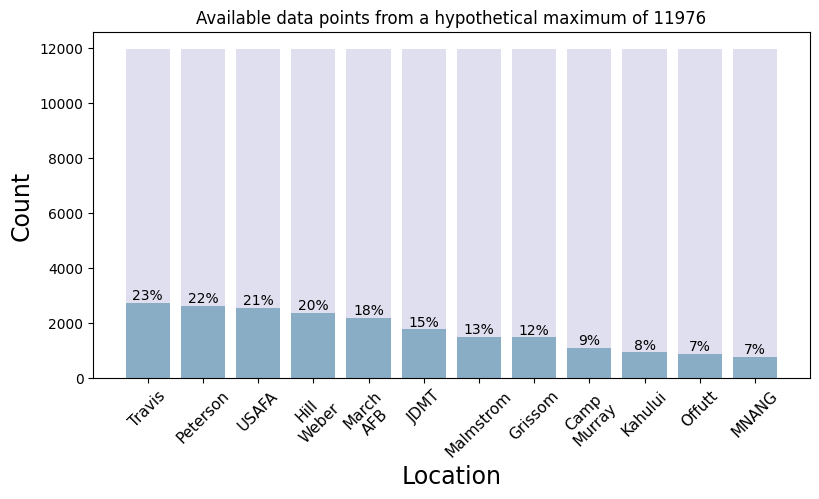

In [4]:
utils.visualise_missing_data(raw)

### Discrepancy between descriptive statistics here and in the paper
Calculating descriptive statistics for the numerical columns, it's noted that the values here differ from those in the paper for some of the features (see `variable units.png`). After investigating, the differences were due to approximately constant scaling factors for each feature, indicating some change of units had taken place. The function `fix_units()` calculates these and transforms the features accordingly. The second set of statistics is then left closely matching those in the paper.

In [5]:
numerical_features = [f for f in raw.columns if f not in ['Datetime', 'Season', 'Latitude', 'Longitude', 'Location']]

raw[numerical_features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].T

,min,25%,50%,mean,75%,max
Altitude,1.000,2.000,458.000,798.844,1370.000,1947.000
Humidity,0.000,17.529,33.124,37.122,52.594,99.988
AmbientTemp,-19.982,21.915,30.289,29.285,37.475,65.738
Wind.Speed,0.000,6.000,9.000,10.318,14.000,49.000
Visibility,0.000,10.000,10.000,9.700,10.000,10.000
Pressure,781.700,845.500,961.100,925.945,1008.900,1029.500
Cloud.Ceiling,0.000,140.000,722.000,515.967,722.000,722.000
PolyPwr,0.257,6.405,13.799,12.979,18.864,34.285


In [6]:
raw_clean = utils.fix_units(raw)

raw_clean[numerical_features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].T

,min,25%,50%,mean,75%,max
Altitude,0.303,0.607,138.932,242.325,415.582,590.612
Humidity,0.000,17.529,33.124,37.122,52.594,99.988
AmbientTemp,-19.982,21.915,30.289,29.285,37.475,65.738
Wind.Speed,0.000,9.665,14.497,16.621,22.551,78.929
Visibility,0.000,16.096,16.096,15.614,16.096,16.096
Pressure,781.700,845.500,961.100,925.945,1008.900,1029.500
Cloud.Ceiling,0.000,4.272,22.029,15.743,22.029,22.029
PolyPwr,0.257,6.405,13.799,12.979,18.864,34.285


With that done, we can rename the column headings and include the appropriate units. We also note at this stage that there are large variations in the scales, max and min values of the features and we'll need some scaling prior to modelling to ensure good performance. 

In [7]:
raw_clean.columns = ['Datetime', 'Location', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'Season',
       'Humidity (%)', 'AmbientTemp (deg C)', 'WindSpeed (km/h)', 'Visibility (km)', 'Pressure (mbar)',
       'CloudCeiling (km)', 'Power (W)']

numerical_features = [f for f in raw_clean.columns if f not in ['Datetime', 'Season', 'Latitude (deg)', 'Longitude (deg)', 'Altitude (m)', 'Location']]

## Exploration of features
We'll begin with an exploration of the entire dataset since that was the approach taken in the paper. If we decide to try forecasting by location, we'll conduct an extra exploration for the specific locations we're interested in. 

### Univariate
The correlation matrix gives the Pearson's correlation between features assuming Gaussian distributions, with magnitudes indicating the strength of the linear relationship. We note that temperature is most highly correlated with the target. Wind speed and pressure have small (<0.1%) correlations, though how informative this is will depend on the shapes of the particular distributions. We note a few high-ish correlations between the base features that we should be aware of: temperature vs humidity (-0.57), cloud ceiling vs humidity (-0.48), and pressure and humidity (+0.43).

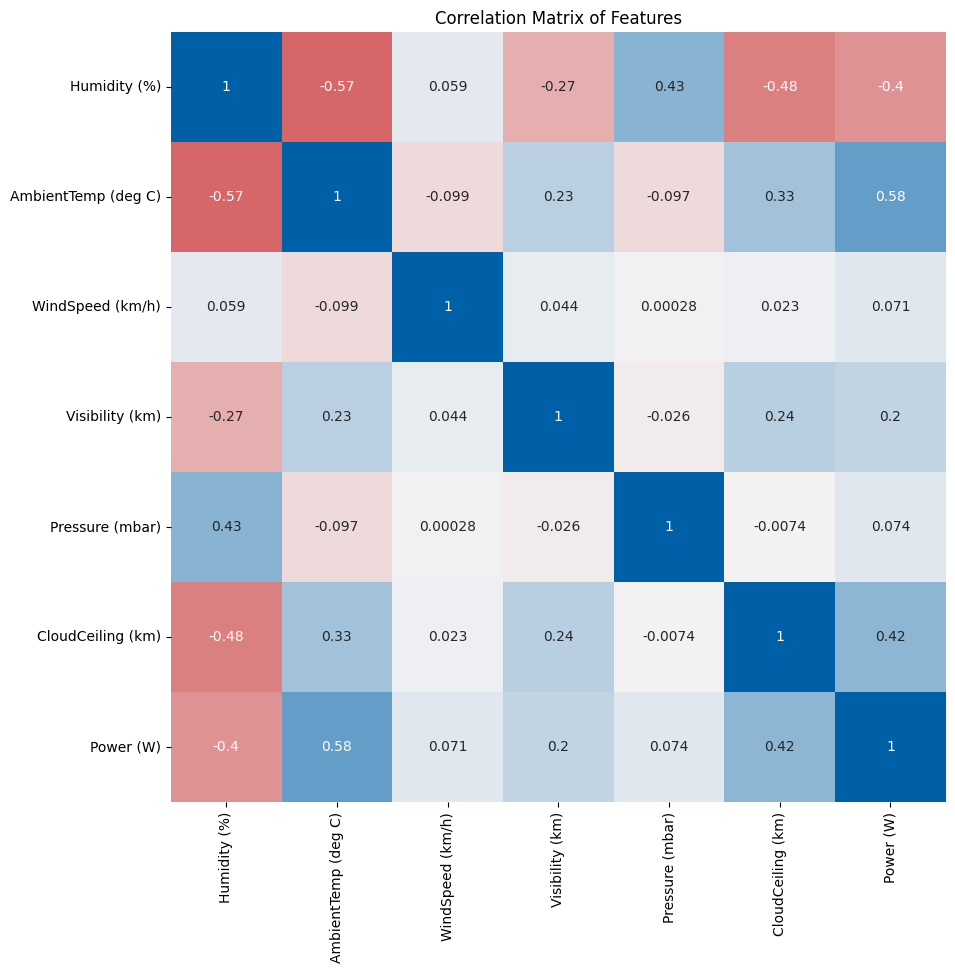

In [8]:
# Correlation
utils.correlation_matrix(raw_clean[numerical_features])

Examining the distribution of the numerical features below, we see that the power, and perhaps pressure and cloud ceiling, may have a bimodal distribution, while visibility looks exponential. The temperature looks approximately normal and humidity and wind speed are skewed towards higher values; all three could potentially benefit from something like a Box–Cox transform to decrease the skew. 

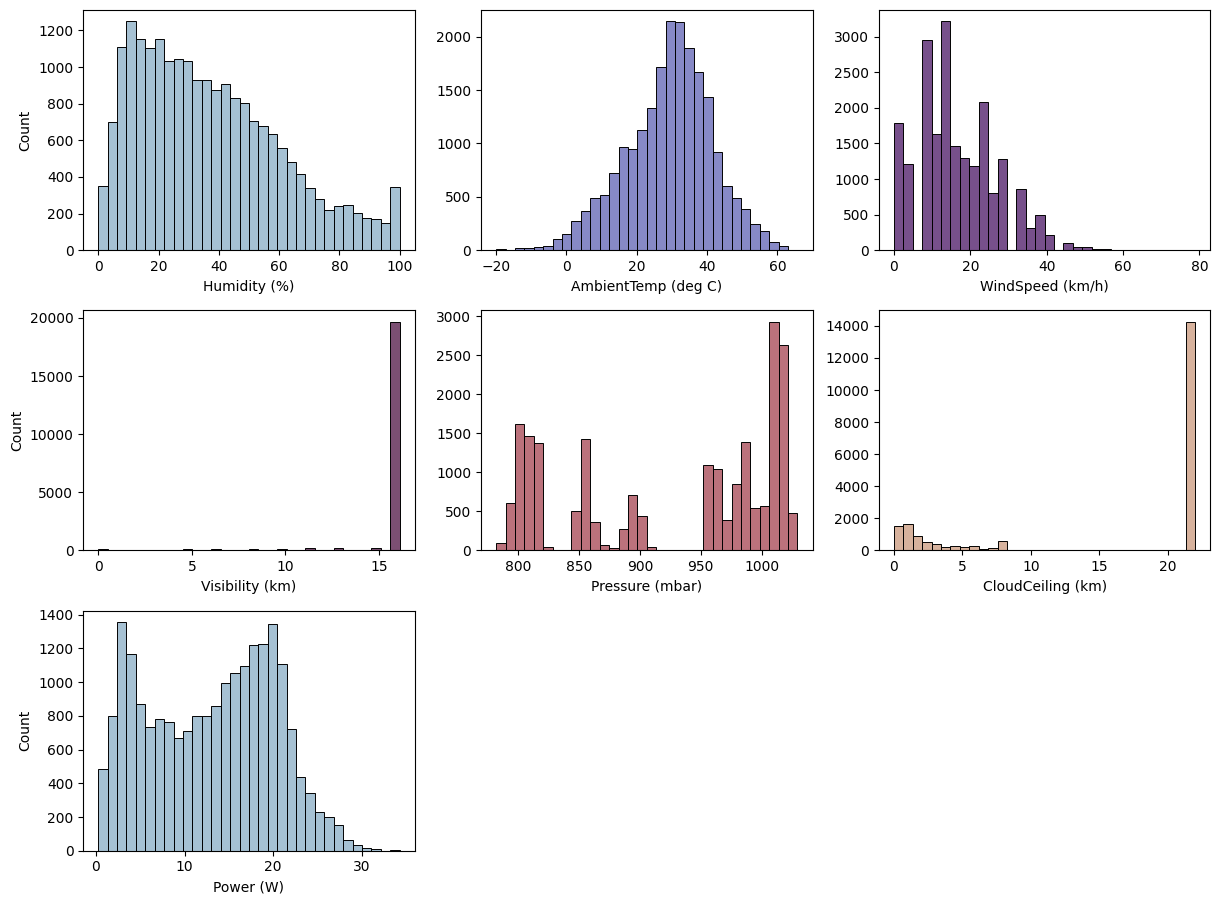

In [9]:
utils.numerical_distributions(raw_clean, numerical_features)

We can see the shape of the distributions more clearly if we plot KDEs.

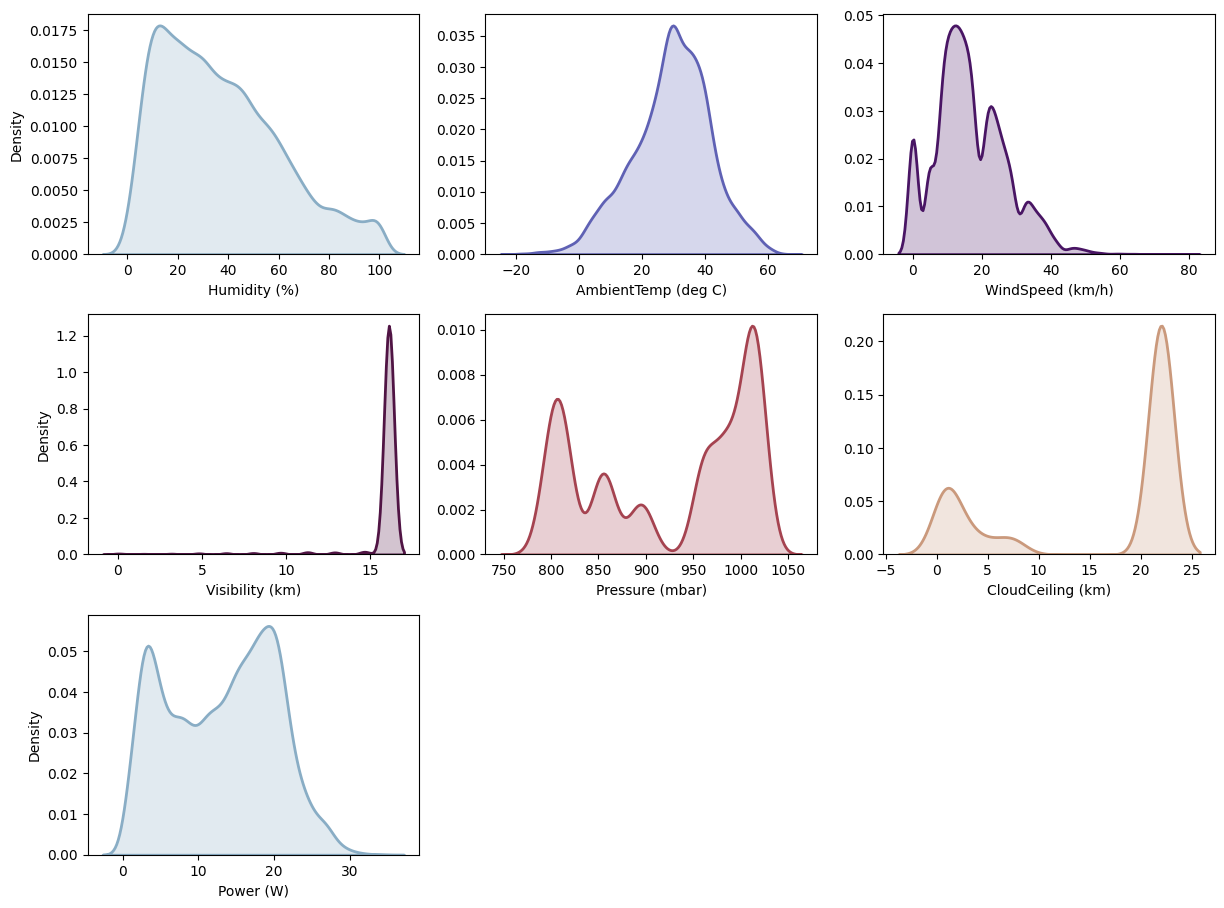

In [10]:
utils.numerical_distributions(raw_clean, numerical_features, plot_type='kde')

The skew can give us supplementary information to the visualisations, indicating (assuming a Gaussian distribution) the extent to which a feature is squashed in one direction or another. This confirms what the visualisations indicated, e.g. that humidity has positive skew while temperature is slightly less skewed, in the opposite direction.

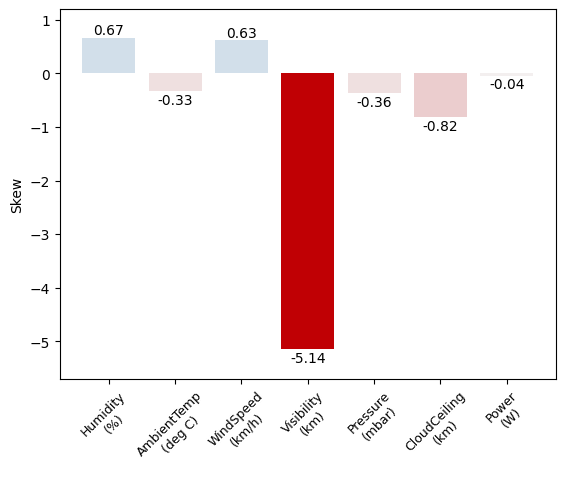

In [11]:
utils.plot_skew(raw_clean, numerical_features)

Another visualisation worth looking over is boxplots, as shown below. From this we can see that in some cases – temperature, wind speed and visibility — we have many outliers, and how to deal with these will have to be considered during modelling. The dataset would also benefit from standardizing to align the means.

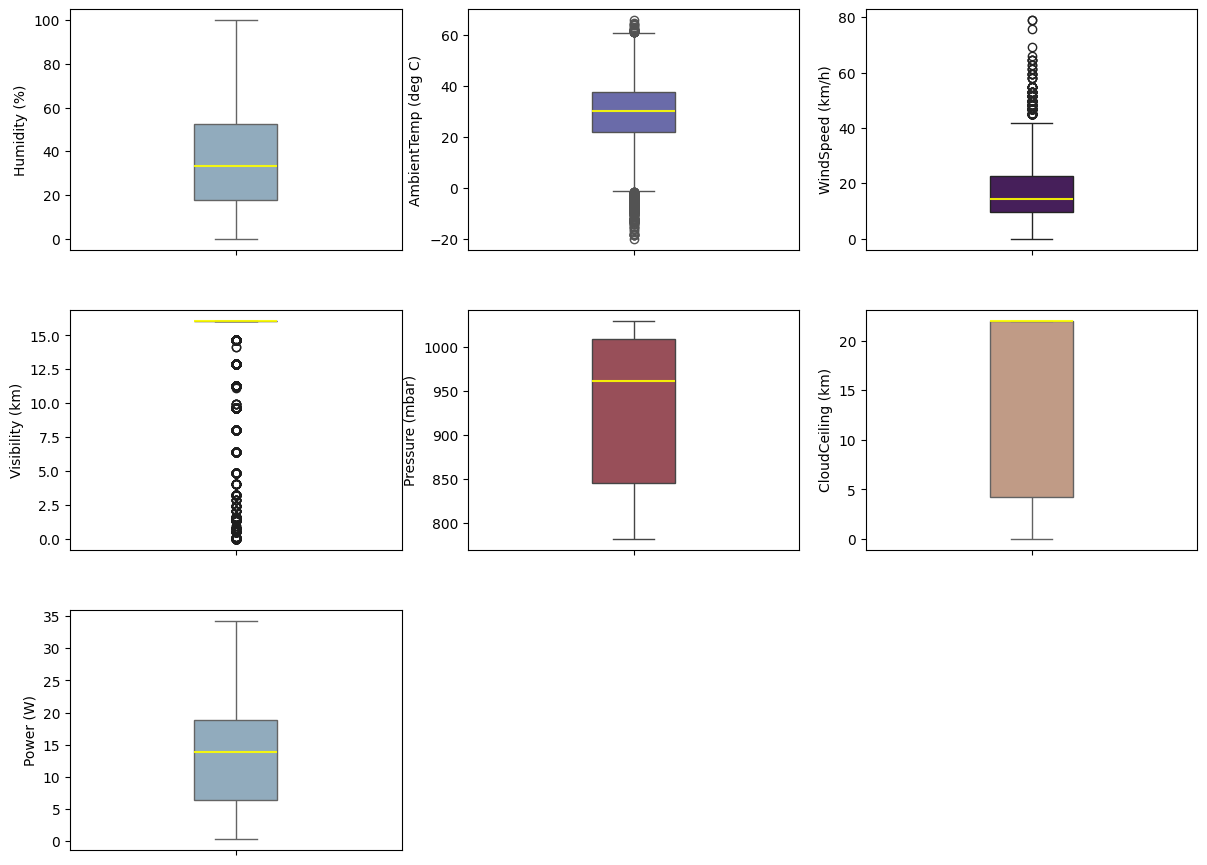

In [ ]:
utils.numerical_distributions(raw_clean, numerical_features, plot_type='box')

We can also check the variation of average power with time of day and month of the year. The shaded areas indicate a value of +/- one standard deviation from the mean and the results are unsurprising. We see an increase in output from the morning towards the middle of the day, where the sun is higher in the sky, before tailing off towards the afternoon; similarly, average power peaks near June and July, when it is summer in the Northern Hemisphere. These could be encoded cyclically or using radial basis functions to represent that, e.g., points for Dec and Jan are close to one another.

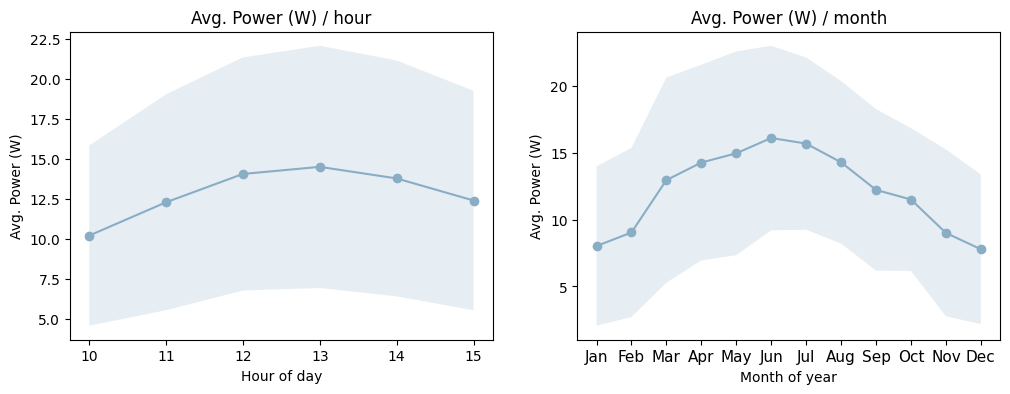

In [ ]:
utils.plot_power_against_time(raw_clean)

### Multivariate
While it's relatively easy to see from the below that the power output varies strongly with location, it's less clear with other features that have more extreme distributions like visibility. If we plot power against visibility for each individual location then we can see that the characteristics of the trend lines change indicating an interaction effect, while following the same procedure but varying by season uncovers similar relationships. 

In [ ]:
utils.compare_box_violins(raw_clean, numerical_features)

interactive(children=(Dropdown(description='Feature', index=6, options=('Humidity (%)', 'AmbientTemp (deg C)',…

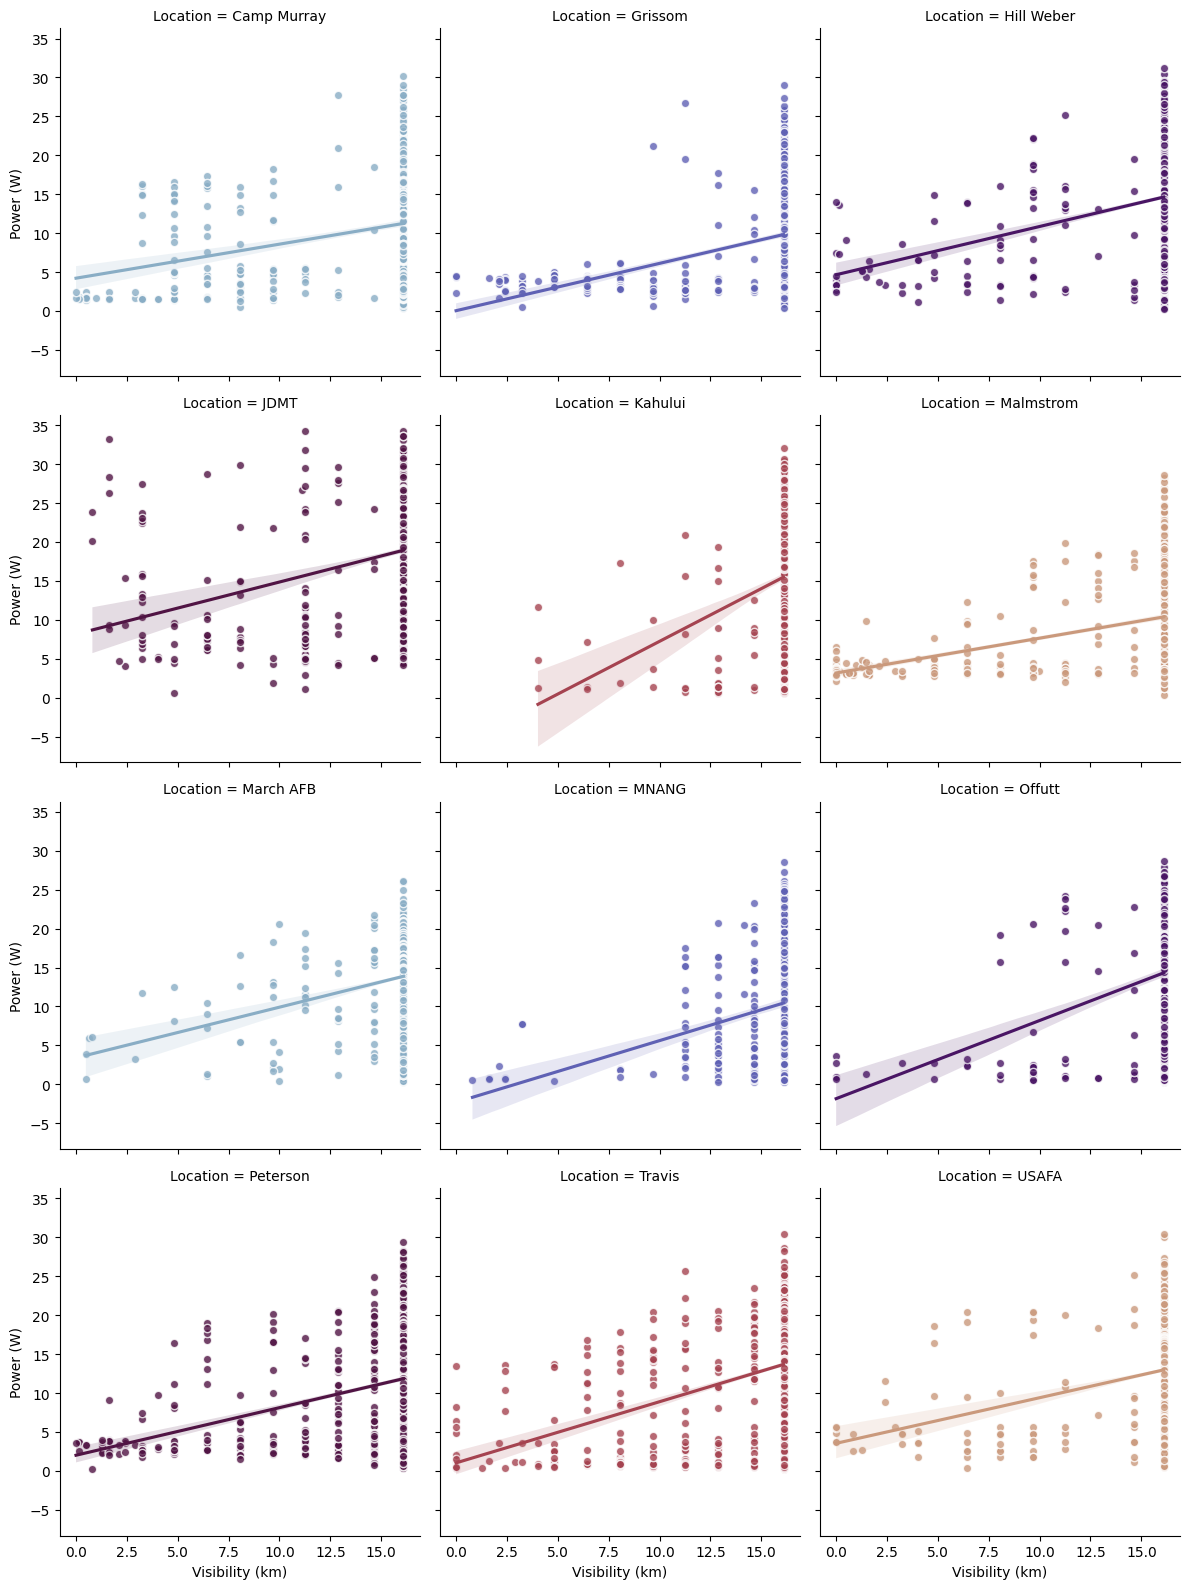

In [ ]:
# feature = "Humidity (%)" - varied gradients
# feature = 'AmbientTemp (deg C)' - varied gradients
# feature = 'WindSpeed (km/h)' - varied gradients
feature = 'Visibility (km)' #- varied gradients, but less so
# feature = 'Pressure (mbar)' #- large variations here
# feature = 'CloudCeiling (km)' - similar gradients but differing intercepts

utils.group_plots(raw_clean, 'Location', feature)    


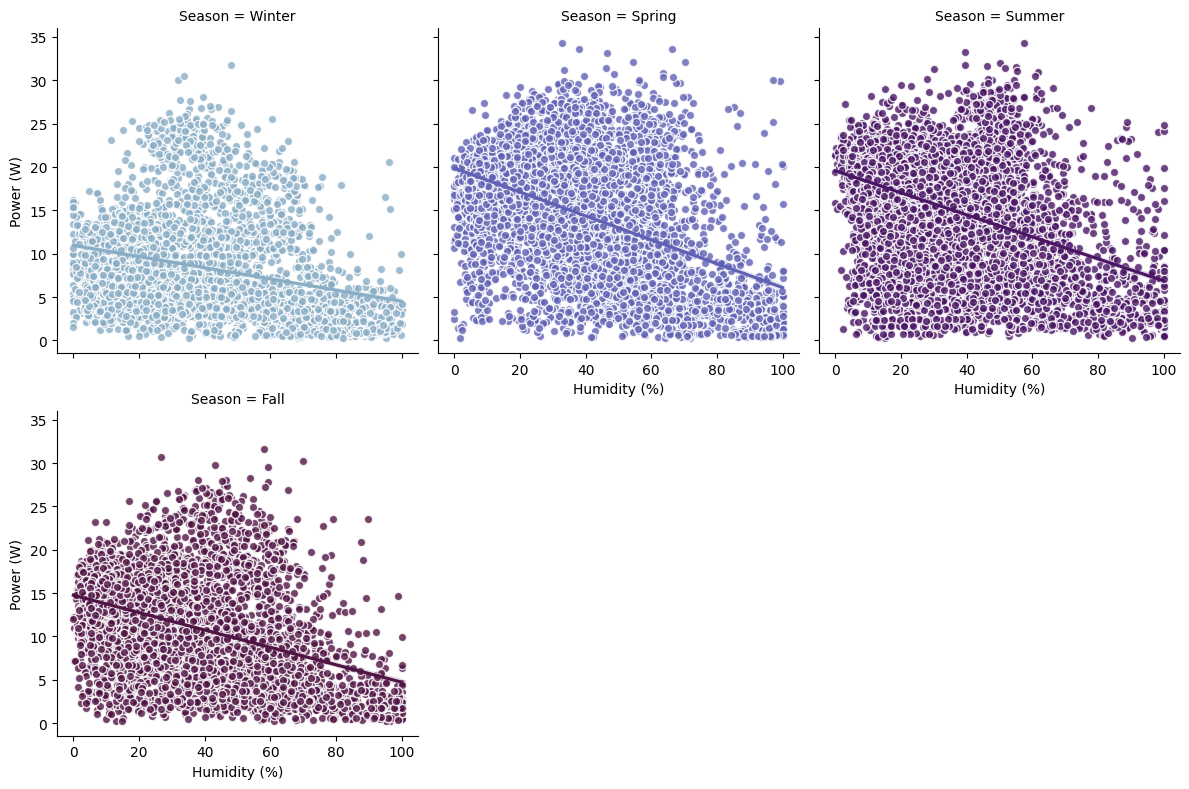

In [ ]:
feature = "Humidity (%)" #- varied gradients
# feature = 'AmbientTemp (deg C)' # - similar gradients, -5 to 5 deg range in intercepts
# feature = 'WindSpeed (km/h)' # - varied gradients
# feature = 'Visibility (km)' #- varied gradients
# feature = 'Pressure (mbar)' # - not huge interactions here
# feature = 'CloudCeiling (km)' #- varied gradients

utils.group_plots(raw_clean, 'Season', feature)